# Reading and plotting solar radio burst data

This notebook shows how to open CDF files of Wind, Stereo-A, PSP and SolO data. It also shows how to plot the time profile of a burst and the dynamic spectrum. (For fitting the decay time of the lightcurves you can look at the read_data.py file)

In [1]:
import os
os.environ["CDF_LIB"] = "~/CDF/lib"
from spacepy import pycdf
from matplotlib import pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from read_rpw_data import read_tnr_autoch_full
import matplotlib.colors as colors
import pandas as pd
import glob
import math
from mpfit import *
from utils import *
from utils_wind_marsis import get_wind_data 

/Users/louissiebenaler/opt/anaconda3/lib/python3.9/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


### Reading CDF files

We define an instrument and file you want to read

In [51]:
#Stereo example
instr = 'STEREO' # alternatively can choose the instrument: WIND / RPW / STEREO / SOLO

file = 'data/sta_l3_wav_hfr_20200711_v01.cdf'

#Wind example
#instr = 'WIND'
#file = 'data/wi_wa_rad1_l3_df_20200711_v01.cdf'

Now we read the CDF file. We are interested in the frequency channels (F), radio wave intensity (I), and time T.

<br> We are defining the index frequency channels we are interested in (defined as fchannels)

In [52]:
if instr == 'RPW':
    cdf = read_tnr_autoch_full(file)
    I = cdf['voltage'].T   
    T, F = cdf['time'][:], cdf['frequency'][:] * 1E3

    fchannels  = np.array([np.argmin((abs(F - 411E3))), np.argmin((abs(F - 430E3))),np.argmin((abs(F - 511E3))) \
          , np.argmin((abs(F - 635E3))), np.argmin((abs(F - 663E3))), np.argmin((abs(F - 755E3))) \
          , np.argmin((abs(F - 788E3))), np.argmin((abs(F - 979E3)))])
    fchannels = np.unique(fchannels)
elif instr == 'WIND':
    cdf = pycdf.CDF(file)
    F, I, T = get_wind_data(cdf)
    F, I, T = F * 1E3, I.T, T.T   #freq units in Hz (kHz actually)

    #need to do this again because wind data is inconsistent with the ordering of the frequency... nervt mech!
    fchannels  = np.array([np.argmin((abs(F[:, 0] - 411E3))), np.argmin((abs(F[:, 0] - 430E3))),np.argmin((abs(F[:, 0] - 511E3))) \
          , np.argmin((abs(F[:, 0] - 635E3))), np.argmin((abs(F[:, 0] - 663E3))), np.argmin((abs(F[:, 0] - 755E3))) \
          , np.argmin((abs(F[:, 0] - 788E3))), np.argmin((abs(F[:, 0] - 979E3)))])
    fchannels = np.unique(fchannels)
    F = F.T
else:
    cdf = pycdf.CDF(file)
    T, I, F = cdf['Epoch'][:], cdf['PSD_FLUX'][:] * 1E22, cdf['FREQUENCY'][:] #intensity units are in sfu, freq units are in Hz
    fchannels  = np.array([np.argmin((abs(F - 411E3))), np.argmin((abs(F - 430E3))),np.argmin((abs(F - 511E3))) \
          , np.argmin((abs(F - 635E3))), np.argmin((abs(F - 663E3))), np.argmin((abs(F - 755E3))) \
          , np.argmin((abs(F - 788E3))), np.argmin((abs(F - 979E3)))])
    fchannels = np.unique(fchannels)

### Visulaizing data

We want to visualize a burst now

#### Dynamic Spectra

To plot the dynamic spectra we use the plotting_dynamic_spectrum function, which is defined in the utils.py file.
<br> We first define the time interval ([ti, tf]) where the burst occurs. We simply read the interval from csv file.

In [53]:
burst_list = pd.read_csv('intervals/WIND_burst_intervals.csv', index_col = 0)  #you can change the file depening which instrument you use

ti, tf = burst_list.B1i.iloc[0], burst_list.B1f.iloc[0] # approximate start and end time of the burst
ti, tf = convert_string_datetime(ti), convert_string_datetime(tf)
datum = burst_list.date.iloc[0]

The structure of the Wind data is weird, hence we need to do this tedious slicing of the data... (There probably is a better way to deal with Wind data)

<IPython.core.display.Javascript object>


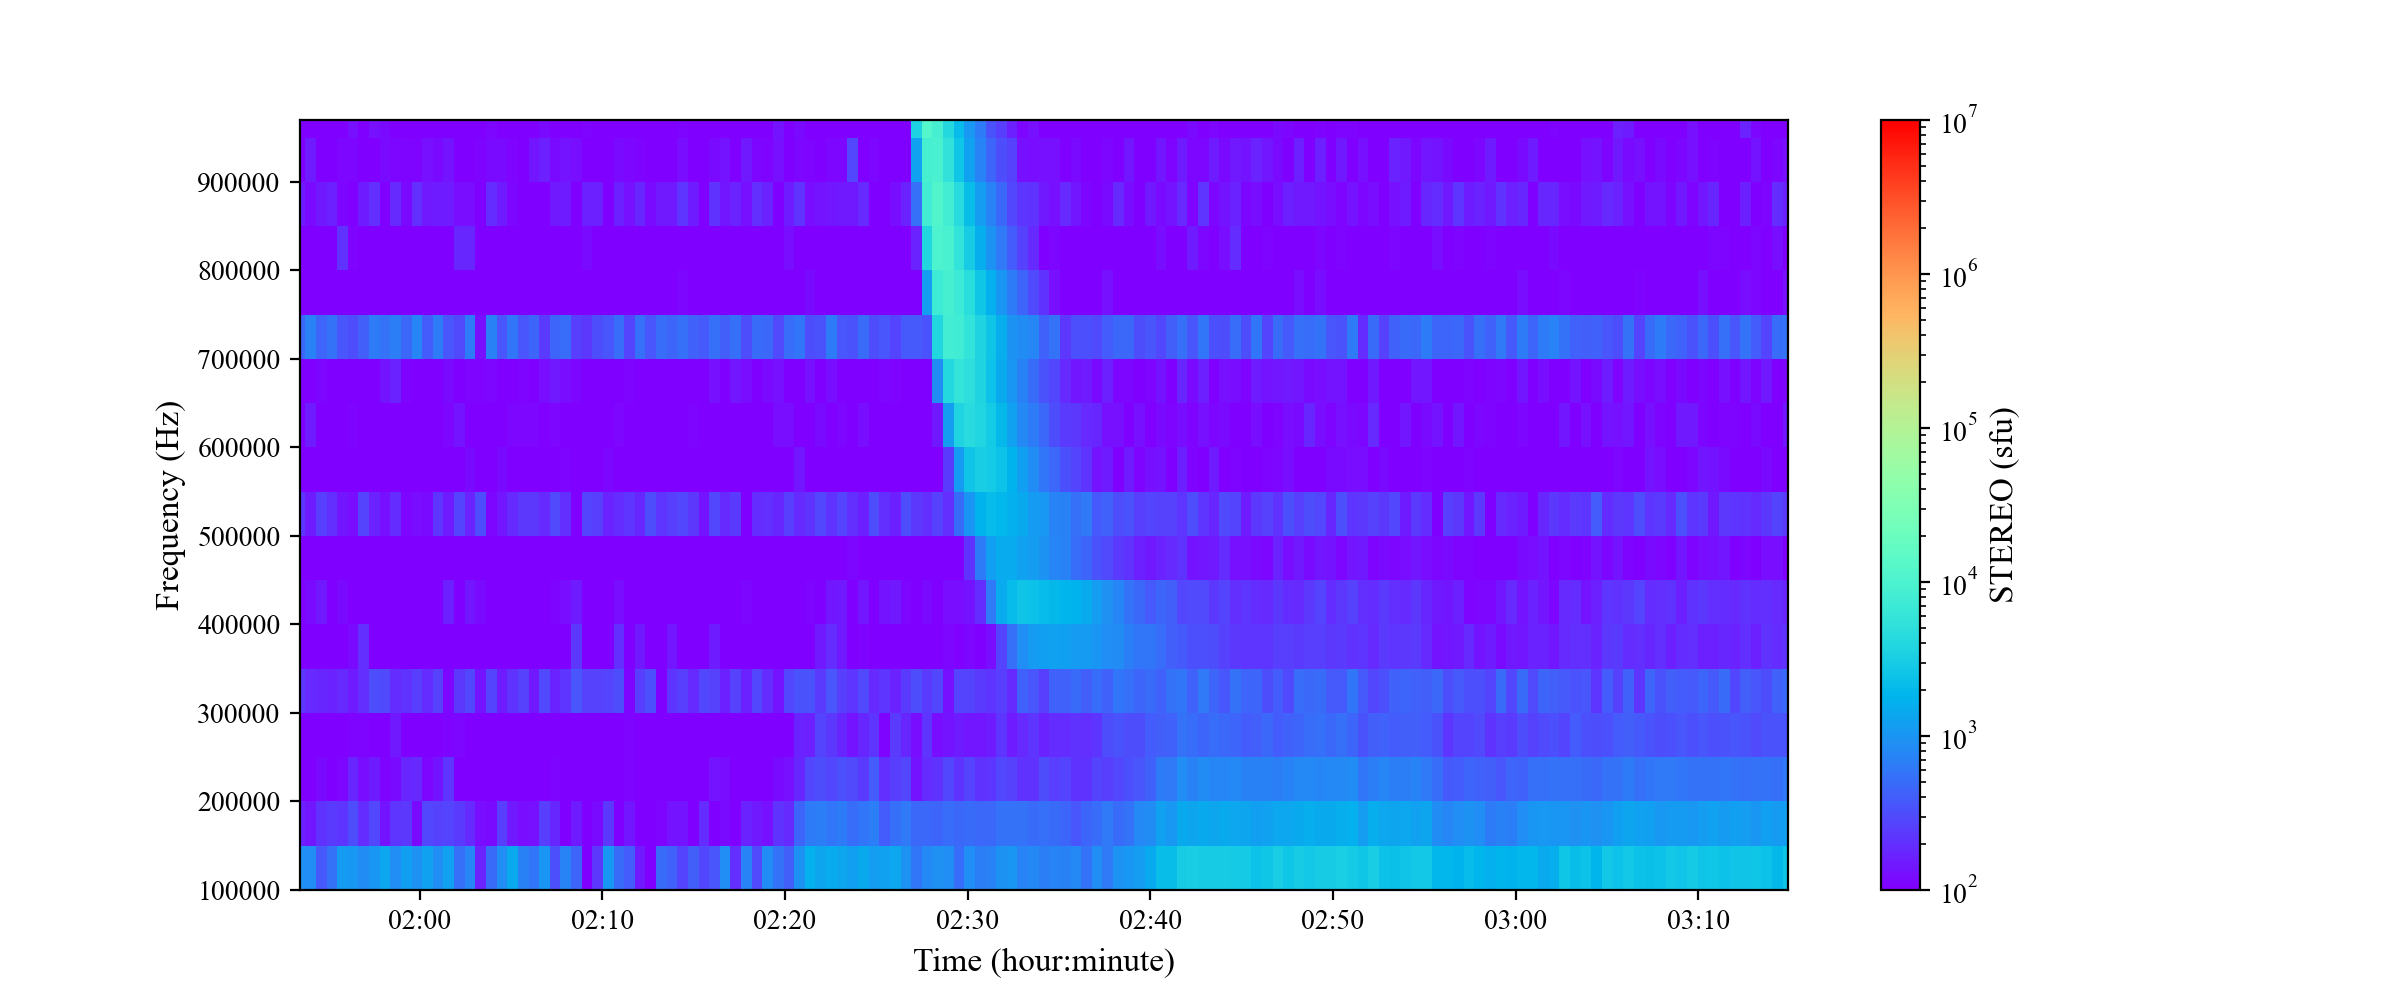

In [54]:
T_copy, I_copy, F_copy = np.copy(T), np.copy(I), np.copy(F) #copies for safety reasons

if instr == 'WIND':
    cdf = pycdf.CDF(file)
    T, I, F = cdf['Epoch'][:], cdf['STOKES_I'][:] *1E22, cdf['FREQUENCY'][:] * 1E3
    F = F[:64]  #there are 64 frequency channels (though some channels like 1040 and 940 are there multiple times for some reason)
    I_new = np.zeros((len(I) // 64, 64))
    F = F[:64]  #there are 64 frequency channels (though some channels like 1040 and 940 are there multiple times for some reason)
    I_new = np.zeros((len(I) // 64, 64))
    try:
            for i in range(64):
                    I_new[:, i] = I[i::64]
            I = I_new
            T = T[::64]
            plotting_dynamic_spectrum(ti, tf, datum, I, T, F, instr)
    except:
            print('Wind structure data is problematic')
else:
        plotting_dynamic_spectrum(ti, tf, datum, I, T, F, instr)

#### Lightcurves

We now want to plot the light curve of a solar radio burst in the data.

<IPython.core.display.Javascript object>


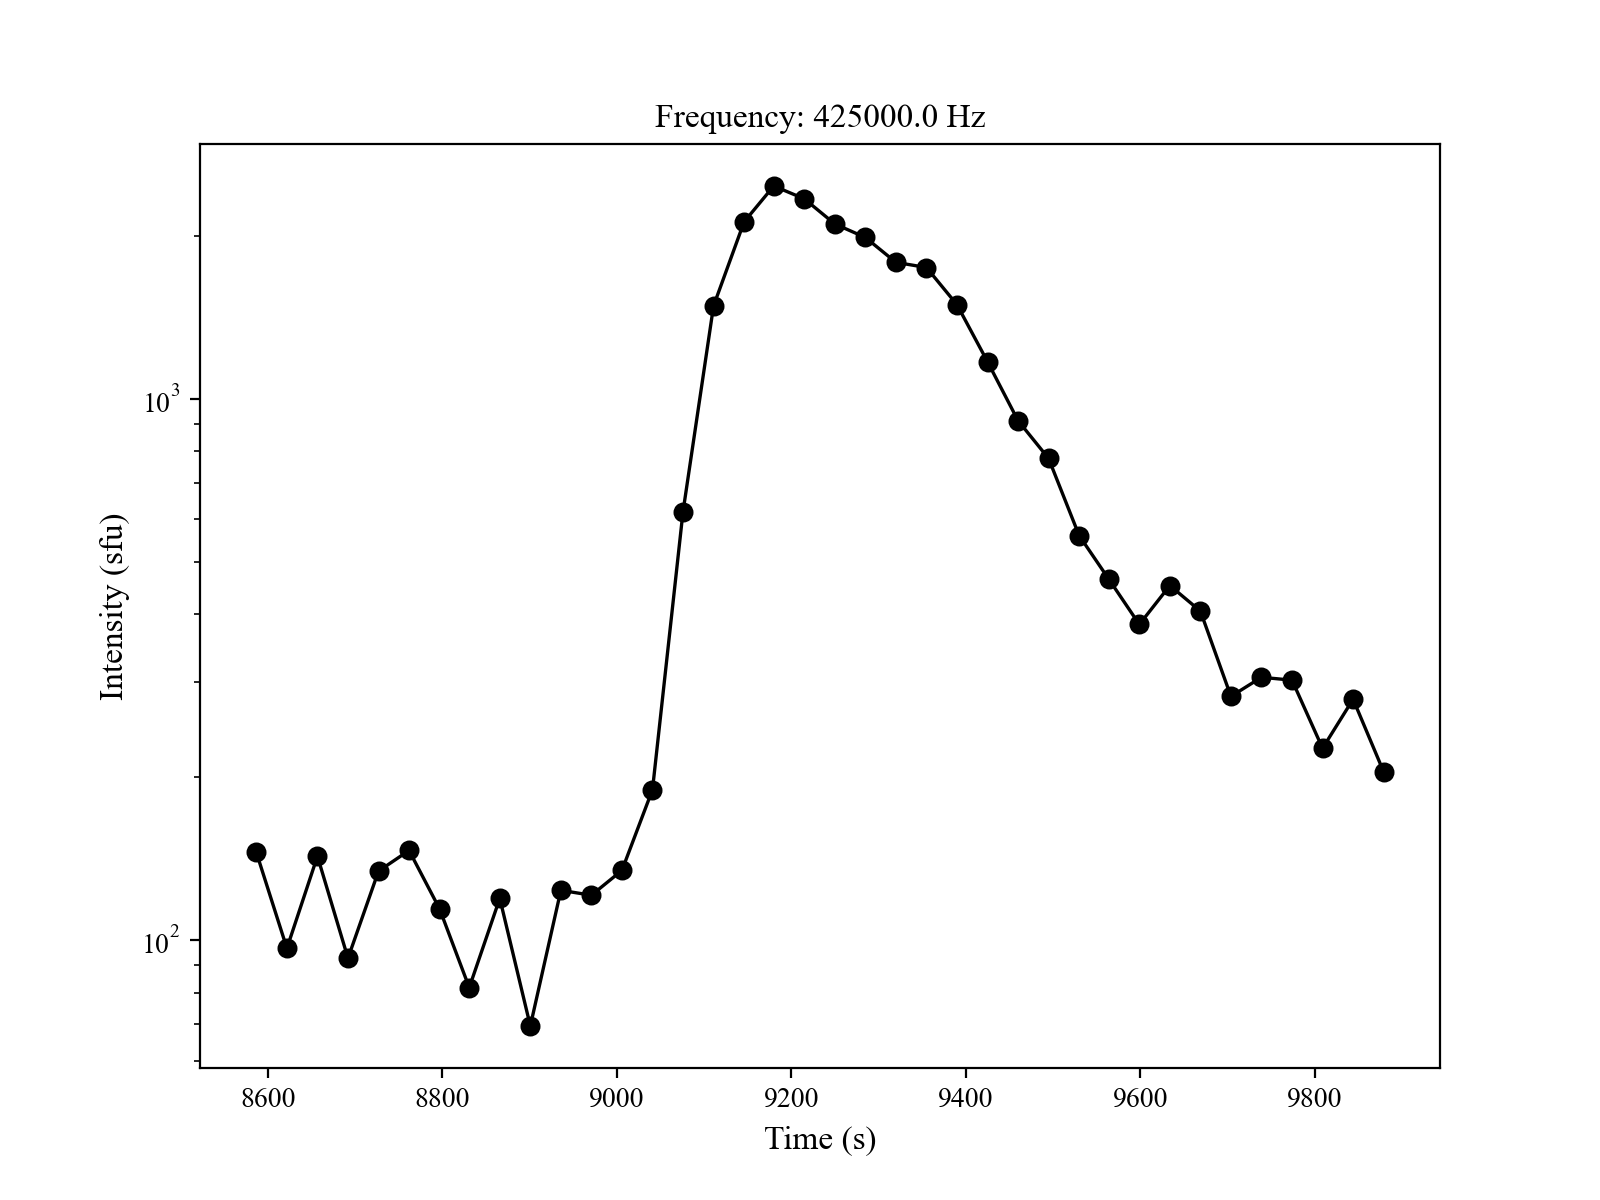

In [55]:
T, I, F = np.copy(T_copy), np.copy(I_copy), np.copy(F_copy)

j = fchannels[0]

if instr == 'WIND':  #Wind data just has a weird structure...
    nz = np.where(F[:, j] != 0)[0]
    F, flux, T = F[nz, j], I[nz, j], T[nz, j]
else:
    flux = I[:, j]   #flux in frequency channel I
    
    
i = get_time_idx(ti, tf, T)
t = to_integer(T[i])  #time in integer format (in seconds only)


fig, ax = plt.subplots(1, 1, figsize = (8, 6))

f = fig.canvas.mpl_connect('key_press_event', on_press)

ax.plot(t, I[i, j], color = 'black', lw = 1.2)
ax.scatter(t, I[i, j], color = 'black', lw = 1.2)
ax.set_yscale('log')
ax.set_title('Frequency: {} Hz'.format(F[j]), fontsize = 12)
ax.set_ylabel('Intensity (sfu)', fontsize = 12)
ax.set_xlabel('Time (s)', fontsize = 12)

plt.show()